The database is composed by several CSV (Comma-Separated Values) files, each one with 8 columns, one column for each sensor, according to:

column 1 tachometer signal that allows to estimate rotation frequency;

columns 2 to 4 underhang bearing accelerometer (axial, radiale tangential direction);

columns 5 to 7 overhang bearing accelerometer (axial, radiale tangential direction);

column 8 microphone.

source: https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

According to the description of the columns there are not one two radial orthogonal accelerometers. Thus, it is not possible to observe the movement orbit of the rotating machine.

On the other hand, perhaps the tangential accelerometer is also moving radially, therefore orthogonal to the radial accelerometer.

Soft-DTW é uma função de perda diferenciável usada em análise de séries temporais, baseada no Dynamic Time Warping (DTW). Permite comparar séries de tamanhos variáveis, é robusta a deslocamentos e dilatações no tempo, e pode ser usada em aprendizado de máquina para tarefas como média, clustering e previsão.


### Desbalanceamento com 20g

- Instalação do soft-DTW:

1 - activate a venv
2 - pip install --upgrade pip setuptools wheel
3 - pip install numpy cython
4 - pip install soft-dtw

In [1]:
# pip install soft-dtw

In [2]:
pip show soft-dtw

Name: soft-dtw
Version: 0.1.6
Summary: Python implementation of soft-DTW
Home-page: https://github.com/mblondel/soft-dtw/
Author: 
Author-email: 
License: Simplified BSD
Location: d:\IFSP\Matematica - Aulas\Codes\math\Lib\site-packages
Requires: chainer, cython, numpy, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from tensorflow.keras import layers, models
# from tensorflow.keras.utils import plot_model
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### 1 - df_desbalanceado_20g

In [4]:
# df_20g = "C:/Files/mafaulda_full/overhang/ball_fault/20g"
# df_normal = "C:/Files/mafaulda_full/normal"
df_unbalance_20g = "C:/Files/mafaulda_bas/imbal_small/20g"

#### 1.1 - Concatenação:

In [5]:
# Lista para armazenar os DataFrames

dataframes = []

# Verifica se o caminho fornecido é um diretório válido
if os.path.isdir(df_unbalance_20g):
    # Iterar pelos arquivos no diretório
    for filename in os.listdir(df_unbalance_20g):
        if filename.endswith(".csv"): 
            file_path = os.path.join(df_unbalance_20g, filename)
            
            try:
                # Lendo o arquivo CSV, pulando a primeira linha (cabeçalho).
                # O parâmetro skiprows=1 é a chave para resolver o problema do 'object' dtype.
                df = pd.read_csv(file_path, sep=',', header=None, skiprows=1)
                dataframes.append(df)
            except Exception as e:
                print(f"Não foi possível ler o arquivo {filename}: {e}")


    if dataframes:
        #Concatenando os dataframes em um único:
        df_unbalance_20g_concat = pd.concat(dataframes, ignore_index=True)

        # Mostrando as primeiras linhas e tipos de dados:
        print("__Dataframe combinado (df_20g_concat) ___")
        print(df_unbalance_20g_concat.head())
        print("\n--- Tipos de dados (dtypes) ---")
        print(df_unbalance_20g_concat.dtypes)
    else:
        print("Não houve leitura de arquivos")
else:
    print(f"diretório df_desbalanceado_20g não encontrado: {df_unbalance_20g}")
    


__Dataframe combinado (df_20g_concat) ___
         0         1         2       3
0 -0.53339  0.001064  0.000731 -2.6298
1 -0.52115 -0.004112 -0.002363 -2.6211
2 -0.52931  0.027923  0.026279 -2.5818
3 -0.53356  0.026850  0.030906 -2.6547
4 -0.51701  0.024686  0.024161 -2.5422

--- Tipos de dados (dtypes) ---
0    float64
1    float64
2    float64
3    float64
dtype: object


- Supondo ultima coluna como rotulos ou classes (y) e as demais como features (X):

In [6]:

X = df_unbalance_20g_concat.iloc[:, :].values         # Todas as colunas
#y = df_unbalance_20g_concat.iloc[:, -1]         # Apenas a última coluna
y = np.full(X.shape[0], 1)  # Criando um array de rótulos com valor 1 para todas as amostras


In [7]:
print("--- Verificação de X e y ---")
# Para NumPy arrays, usamos fatiamento para ver o "cabeçalho" e .dtype para o tipo de dado
print("X head:\n", X[:5]) # Mostra as primeiras 5 linhas (fatiamento de array)
print("\nX numpy dtype:", X.dtype) # Mostra o tipo de dado do array NumPy
print("\ny head:\n", y[:5]) # Mostra as primeiras 5 linhas de y
print("\ny dtypes:", y.dtype) # Mostra o tipo de dado do array NumPy
print('--------------------------------------')
print("X shape:", X.shape)
print("y shape:", y.shape)
print('--------------------------------------')
print('ooooooooooooooooooooooooooooooooooooo')


--- Verificação de X e y ---
X head:
 [[-5.3339e-01  1.0645e-03  7.3059e-04 -2.6298e+00]
 [-5.2115e-01 -4.1120e-03 -2.3626e-03 -2.6211e+00]
 [-5.2931e-01  2.7923e-02  2.6279e-02 -2.5818e+00]
 [-5.3356e-01  2.6850e-02  3.0906e-02 -2.6547e+00]
 [-5.1701e-01  2.4686e-02  2.4161e-02 -2.5422e+00]]

X numpy dtype: float64

y head:
 [1 1 1 1 1]

y dtypes: int64
--------------------------------------
X shape: (12249951, 4)
y shape: (12249951,)
--------------------------------------
ooooooooooooooooooooooooooooooooooooo


#### 1.2 - Normalização:

- É um comportamento esperado do pandas. Essa linha não se refere a uma coluna específica do seu DataFrame. Ela descreve o tipo de dados da própria lista de tipos que está sendo exibida. Como a lista contém vários objetos de tipo float64 e outros, o pandas a classifica como uma série de tipo object.
- fit (Ajustar/Aprender): A primeira parte, fit, "olha" para cada coluna (cada sensor), calcula a média (μ) e o desvio padrão (σ) daquela coluna específica, aprendendo os parâmetros de distribuição dos dados.

In [8]:
# Função para normalizar os dados. preprocess_data padroniza os dados antes de entregá-los ao modelo para tr

print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")

def preprocess_data(data_to_scale):                                  # X  é o conjunto de dados de entrada (as leituras dos 8 sensores de vibração
    print("   'X_scaled' foi criado com sucesso!")
    scaler = StandardScaler()
    scaled_data_out = scaler.fit_transform(data_to_scale)
        
    # VISUALIZAR OS DADOS NORMALIZADOS
    print("\n2. Gerando gráficos para visualização...")
    return scaled_data_out




1. Aplicando a normalização (StandardScaler) aos dados de X...


### 1.3 - Análise do sinal do acelerômetro com medição no eixo radial:

In [9]:
# print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")
X_scaled = preprocess_data(X)   # <--- CHAMA A FUNÇÃO E OBTÉM O RESULTADO
print("   'X_scaled' foi criado com sucesso!")
print(f"   Formato do X_scaled: {X_scaled.shape}, Tipo: {type(X_scaled)}")
print('-----------------------------------------')

# --- VISUALIZAR OS DADOS NORMALIZADOS (Plotagem) ---
print("\n2. Gerando gráficos para visualização...")


   'X_scaled' foi criado com sucesso!

2. Gerando gráficos para visualização...
   'X_scaled' foi criado com sucesso!
   Formato do X_scaled: (12249951, 4), Tipo: <class 'numpy.ndarray'>
-----------------------------------------

2. Gerando gráficos para visualização...


PLOTAGEM COM TEMPO INICIAL CURTO


C:\Users\carlo\AppData\Local\Temp\ipykernel_15984\3373165478.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\IFSP\Matematica - Aulas\Codes\math\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


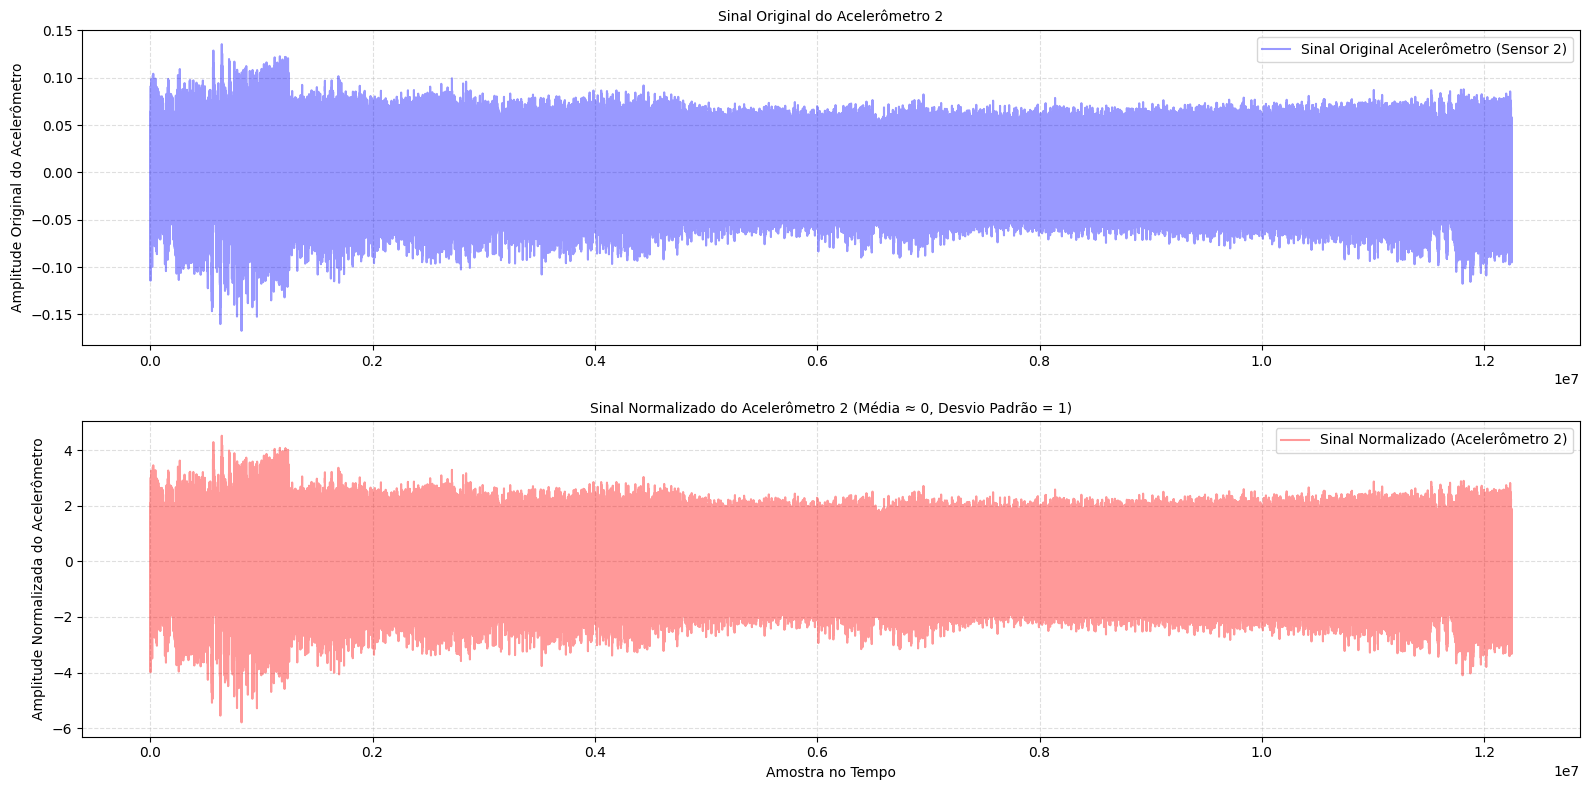

PLOTAGEM COM TEMPO INICIAL LONGO


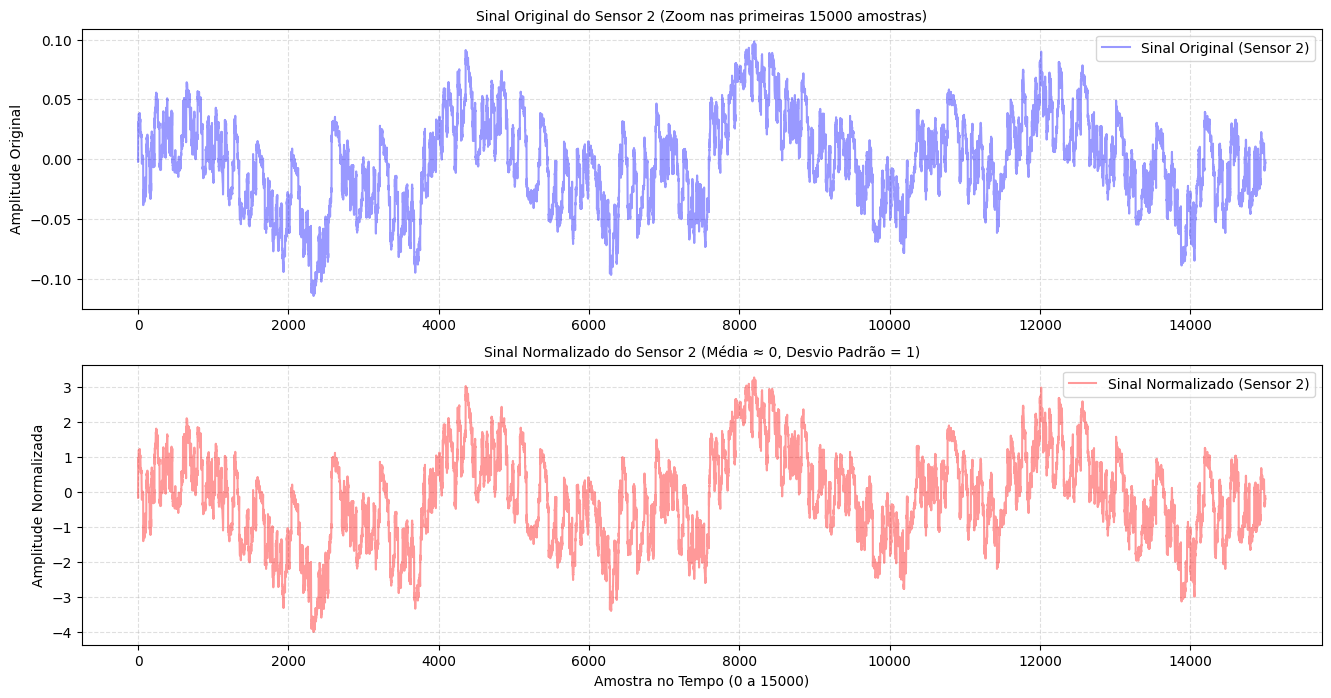

In [10]:


sensor_a_visualizar = 2 # acelerômetro overhang sinal radial.
num_amostras_plot = 15000

# Acessa os dados originais (X deve ser um array NumPy)
raw_imbal_signal = X[:, sensor_a_visualizar]
# Acessa os dados já escalados
scaled_imbal_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))


# plotagem com tempo inicial curto:
print("PLOTAGEM COM TEMPO INICIAL CURTO")

# Gráfico do sinal original
plt.subplot(2, 1, 1)
plt.plot(raw_imbal_signal, label=f'Sinal Original Acelerômetro (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Acelerômetro {sensor_a_visualizar}', fontsize=10)
plt.ylabel('Amplitude Original do Acelerômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
plt.plot(scaled_imbal_signal, label=f'Sinal Normalizado (Acelerômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Acelerômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel('Amostra no Tempo', fontsize=10)
plt.ylabel('Amplitude Normalizada do Acelerômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


# plotagem com tempo inicial LONGO:
print("PLOTAGEM COM TEMPO INICIAL LONGO")

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
# Aplica o fatiamento com o novo número de amostras
plt.plot(raw_imbal_signal[:num_amostras_plot], label=f'Sinal Original (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Sensor {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
# Aplica o fatiamento com o novo número de amostras
plt.plot(scaled_imbal_signal[:num_amostras_plot], label=f'Sinal Normalizado (Sensor {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Sensor {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostra no Tempo (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

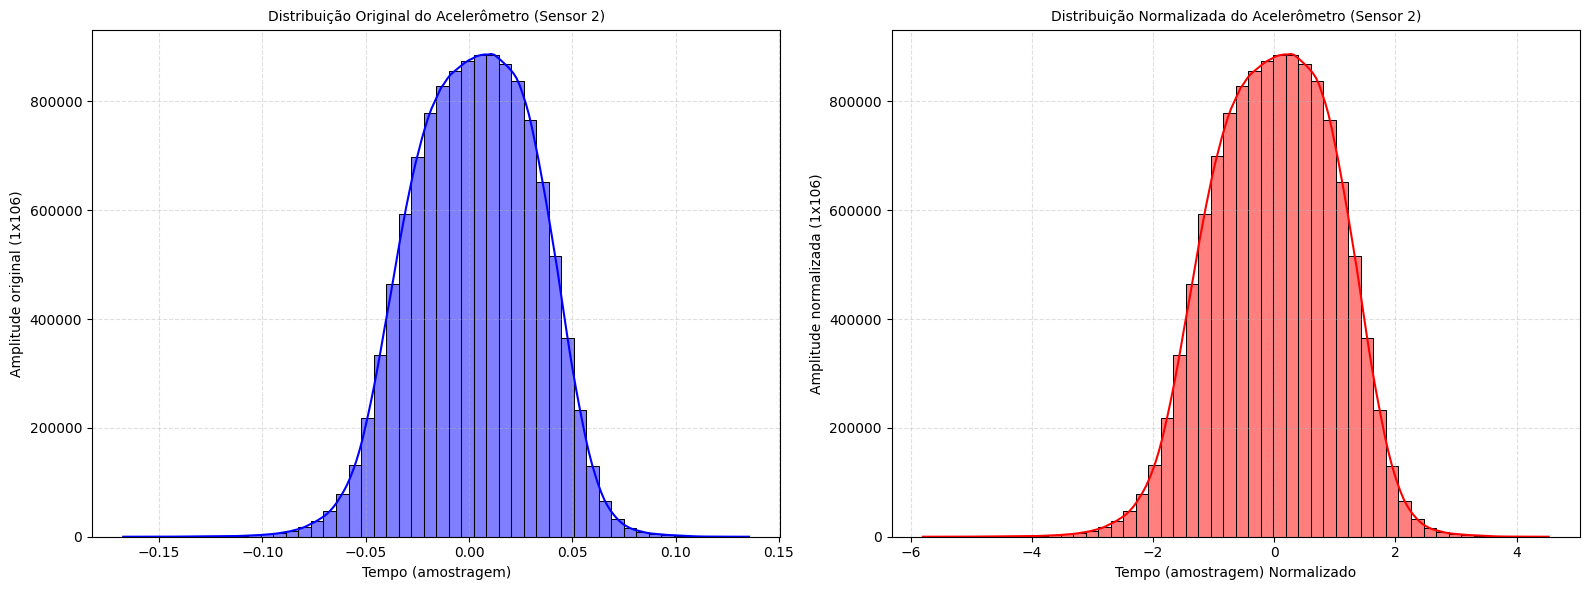


Visualização concluída.


In [11]:
# --- Gráfico 2: Comparação da Distribuição dos Dados (Histograma) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_imbal_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição Original do Acelerômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem)', fontsize=10)
plt.ylabel('Amplitude original (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_imbal_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição Normalizada do Acelerômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem) Normalizado', fontsize=10)
plt.ylabel('Amplitude normalizada (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

### Métricas Estatísticas:

#### Tecnicas no domınio da frequencia: Analise espectral

- O defeito de desbalanceamento pode ser identificado atraves da analise espectral e caracteriza-se por ocorrer na frequencia de rotaçao da maquina, onde se detecta uma alta amplitude. Nas direçoes radiais a sensibilidade e maior em relaçao `a direçao axial, devido ao fato da forca centrıfuga, gerada pelo desbalanceamento, ocorrer na
posiçao radial. Se o sinal referente a posiçao radial apresentar maior amplitude em relaçao `a posiçao axial, na frequencia de rotaçao da maquina, o defeito e desbalanceamento. A figura 2.18 mostra dois espectros sobrepostos com a finalidade de apreciar visualmente o efeito de desbalanceamento na frequencia.

- A amplitude de vibração é diretamente proporcional ao grau de desbalanceamento, se dobrar o valor da massa desbalanceadora, automaticamente também dobra a amplitude de vibração.

#### Transformada de fourier:

- Incluir libraries:

In [12]:
%pip install -U scipy

Note: you may need to restart the kernel to use updated packages.


In [14]:
from scipy.fft import rfft, rfftfreq
from scipy import integrate

#### Transformada Rápida de Fourier (rFFT)

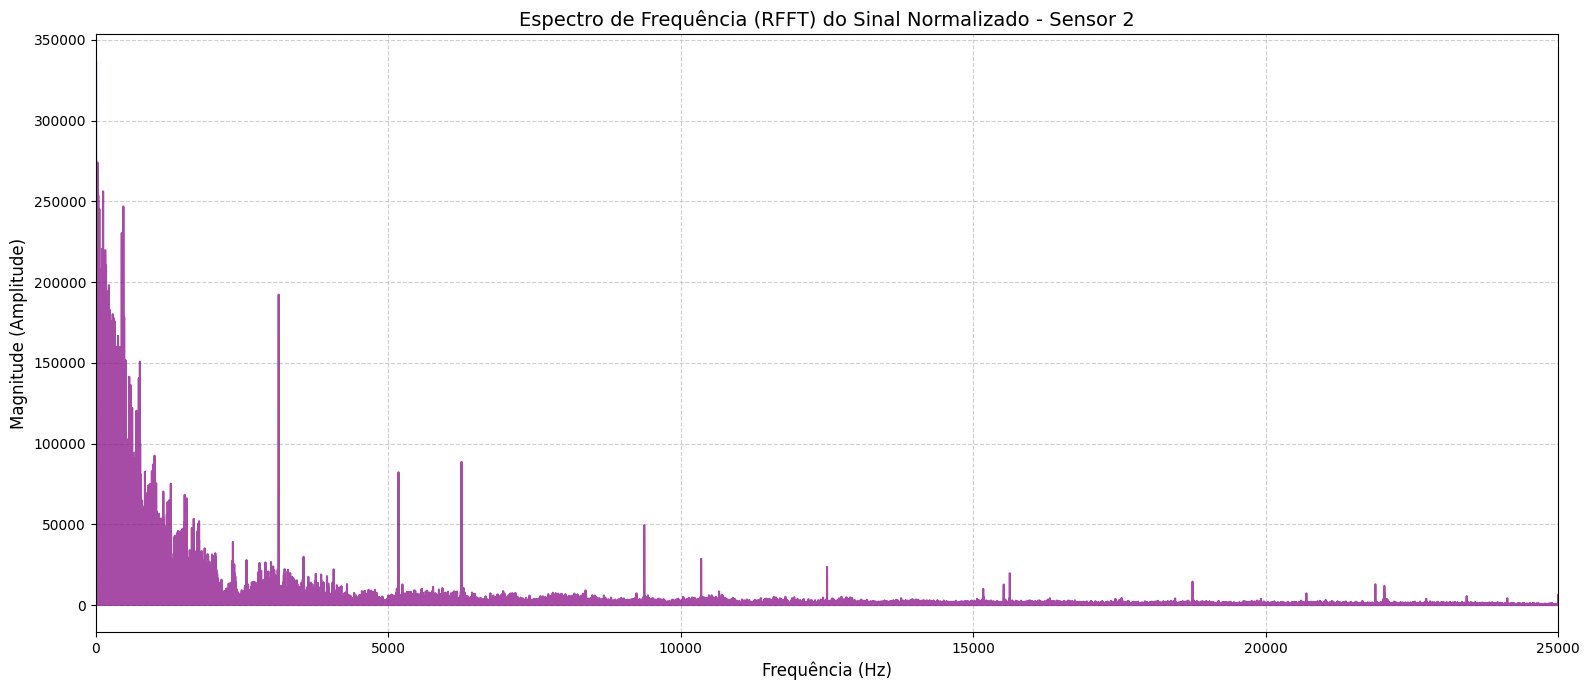


Plotagem da RFFT concluída.


In [ ]:
SAMPLE_RATE = 50000 # Hz (50 kHz) 

# 1. Calcular a Transformada Rápida de Fourier Real (RFFT)
fft_values = rfft(scaled_imbal_signal['Sensor_2'])

# 2. Calcular as frequências correspondentes aos valores da FFT onde N é o núm. de pontos no sinal de tempo
N = len(scaled_imbal_signal['Sensor_2'])
frequencies = rfftfreq(N, 1 / SAMPLE_RATE) 

# --- Plotagem da Magnitude da RFFT ---
plt.figure(figsize=(16, 7))
plt.plot(frequencies, np.abs(fft_values), color='purple', alpha=0.7)
plt.title(f'Espectro de Frequência (RFFT) do Sinal Normalizado - Sensor {sensor_a_visualizar}', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Amplitude)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, SAMPLE_RATE / 2) # Limita o eixo X à frequência de Nyquist
plt.tight_layout()
plt.show()

print("\nPlotagem da RFFT concluída.")

- A plotagem exibe o espectro de frequência (RFFT) do sinal de vibração, medido pelo acelerômetro radial na parte externa do eixo (over-hung). Este gráfico de frequência serve para o diagnóstico de falhas, pois cada pico representa a magnitude de componentes vibracionais em frequências específicas. Como a medição radial é sensível a desbalanceamentos, desalinhamentos e folgas, detectamos vibrações significativas nas frequências de rotação do eixo (1X RPM) e em seus múltiplos inteiros (2X, 3X, etc.). A análise deste espectro permite identificar a energia associada a essas frequências, fornecendo uma "assinatura" da condição da máquina para diagnóstico e monitoramento.

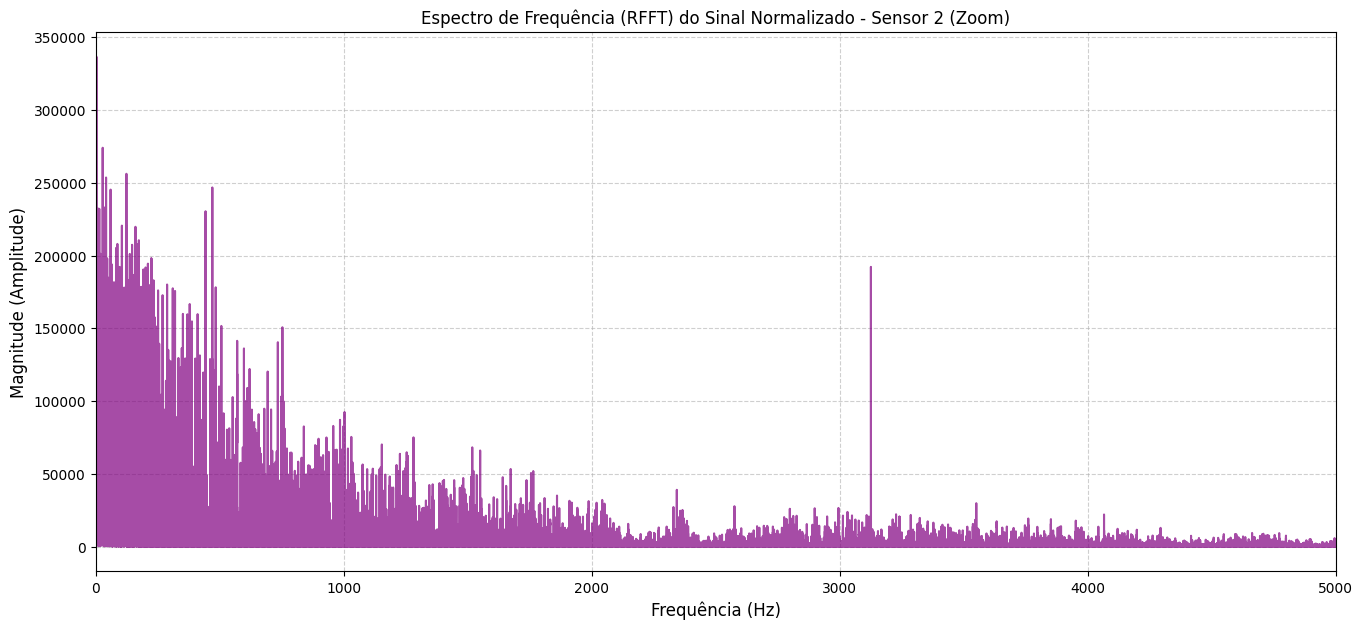

In [21]:
#Dando um zoom na região de interesse (até 10 KHz.)

# --- Plotagem da Magnitude da RFFT com Zoom ---
plt.figure(figsize=(16, 7))
plt.plot(frequencies, np.abs(fft_values), color='purple', alpha=0.7)
plt.title(f'Espectro de Frequência (RFFT) do Sinal Normalizado - Sensor {sensor_a_visualizar} (Zoom)', fontsize=12)
plt.xlim(0, 5000)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Amplitude)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

In [34]:
imbal = raw_imbal_signal
SAMPLE_RATE = 50000 # Hz (50 kHz) 

In [35]:
N = imbal.shape[0]

def acel_spectrum(x_acel):
    x_acel = x_acel - np.mean(x_acel)

    yf = rfft(x_acel)
    xf = rfftfreq(N, 1 / SAMPLE_RATE)

    plt.plot(xf, np.abs(yf))
    plt.title("Accel_Spectrum")
    plt.show()


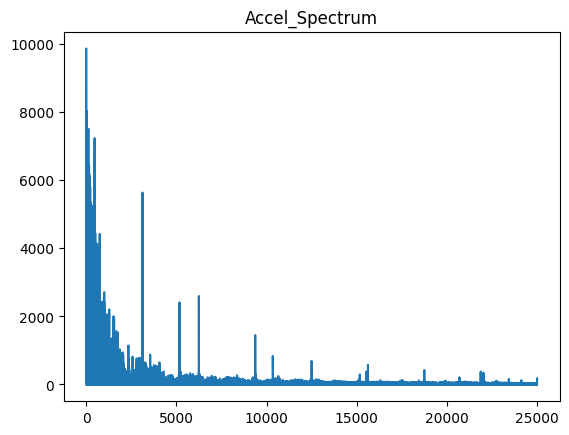

In [36]:
acel_spectrum(imbal)


--- Gerando Espectro de Aceleração Normalizado ---


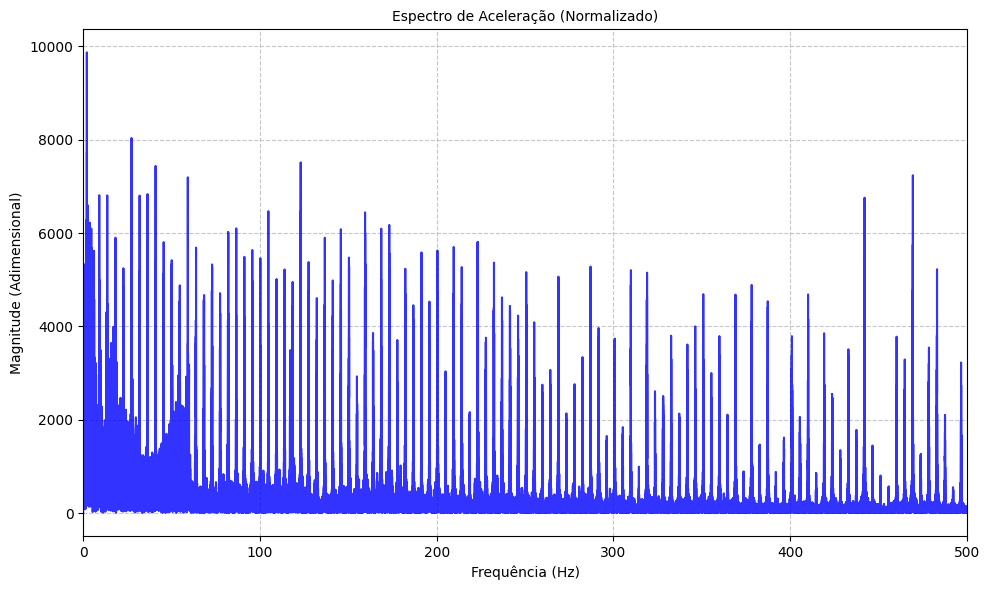


Algoritmo de plotagem do espectro de aceleração concluído.


In [38]:
# 'scaled_overhang_signal', ou o sinal do acelerômetro normalizado.

def acel_spectrum(x_acel):
    """
    Calcula o espectro de aceleração a partir de um sinal de aceleração normalizado,
    removendo a média e aplicando a RFFT.
    """
    #Remover a média (componente DC) do sinal normalizado, se ainda não foi removida ou para garantir.
    x_acel = x_acel - np.mean(x_acel)

    yf = rfft(x_acel)
    # CORREÇÃO: N para rfftfreq deve ser o comprimento do sinal x_acel
    N_signal = len(x_acel)
    xf = rfftfreq(N_signal, 1 / SAMPLE_RATE)

    # --- Plotagem do Espectro de Aceleração com Unidades ---
    plt.figure(figsize=(10, 6)) # Define o tamanho da figura para melhor visualização
    plt.plot(xf, np.abs(yf), color='blue', alpha=0.8) # Plota a magnitude do espectro
    plt.title("Espectro de Aceleração (Normalizado)", fontsize=10)
    plt.xlabel("Frequência (Hz)", fontsize=10) 
    plt.ylabel("Magnitude (Adimensional)", fontsize=10) 
    
    # Definir limites de plotagem em uma faixa de interesse específica.
    plt.xlim([0, SAMPLE_RATE / 2]) # Para mostrar até a frequência de Nyquist
    plt.xlim([0, 500]) # zoom até 500 Hz
    
    plt.grid(True, linestyle='--', alpha=0.7) # Adiciona grade
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show() # Exibe o gráfico

# --- CHAMADA DA FUNÇÃO NO ESCOPO GLOBAL ---
print("\n--- Gerando Espectro de Aceleração Normalizado ---")
acel_spectrum(imbal)

print("\nAlgoritmo de plotagem do espectro de aceleração concluído.")

In [40]:
from scipy.signal import butter, filtfilt

# Desenvolvimento de um FPB:
if 'SAMPLE_RATE' not in locals(): #se taxa de amostragem não presente....
    
    SAMPLE_RATE = 52000 # Hz
    
# Se 'raw_imbal_signal' não estiver definido, avisa e ENCERRA.
if 'raw_imbal_signal' not in locals() and 'raw_imbal_signal' not in globals():
    print("ERRO: 'raw_imbal_signal' não encontrado.")
    
    raise SystemExit("Execução interrompida devido à ausência de 'raw_imbal_signal'.")
    
print("\n--- Aplicando Filtro Passa-Banda ao Sinal do Acelerômetro Normalizado ---")



--- Aplicando Filtro Passa-Banda ao Sinal do Acelerômetro Normalizado ---


#### --- 1. Definir Parâmetros do Filtro Passa-Banda ---

In [41]:
# Deve-se definir a banda de ressonância da sua máquina.
# Estes são valores EXEMPLO:
fc_low = 50  # Frequência de corte inferior (Hz) - Exemplo: 2 kHz
fc_high = 2000 # Frequência de corte superior (Hz) - Exemplo: 8 kHz
order = 3      # Ordem do filtro (quanto maior, mais íngreme o corte, mas pode introduzir mais atraso)

#### 2. Normalizar as Frequências de Corte

In [42]:
# As frequências de corte são normalizadas pela frequência de Nyquist (SAMPLE_RATE / 2).
nyquist = 0.5 * SAMPLE_RATE
normal_fc_low = fc_low / nyquist
normal_fc_high = fc_high / nyquist

#### 3. Projetar o Filtro Butterworth Passa-Banda

In [43]:
# 'b' e 'a' são os coeficientes do numerador e denominador do filtro.
b, a = butter(order, [normal_fc_low, normal_fc_high], btype='band', analog=False)

#### 4. Aplicar o Filtro ao Sinal

In [45]:

# 'filtfilt' aplica o filtro para frente e para trás, eliminando o atraso de fase.
signal_filtered = filtfilt(b, a, raw_imbal_signal)

print(f"Filtro Passa-Banda aplicado: {fc_low}-{fc_high} Hz, Ordem: {order}")

Filtro Passa-Banda aplicado: 50-2000 Hz, Ordem: 3


#### --- 5. Plotar o Sinal Original e o Sinal Filtrado (Zoom no Tempo) ---

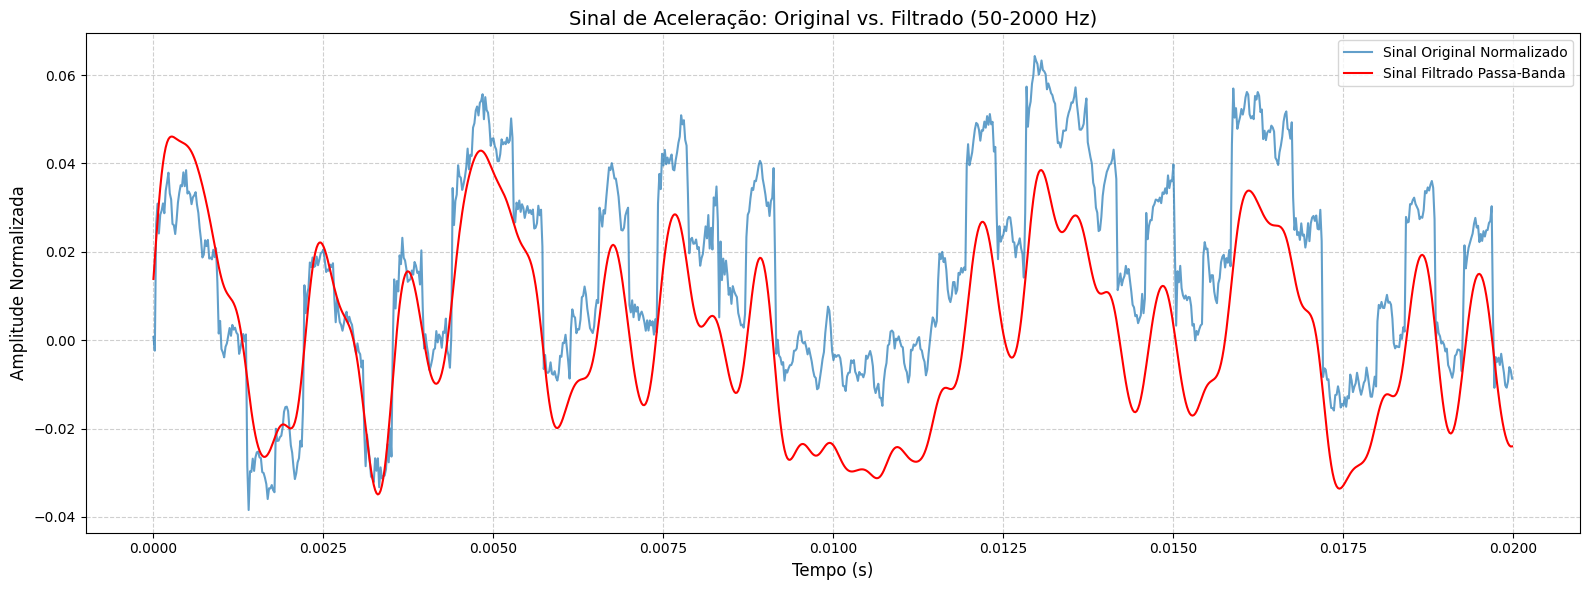

C:\Users\carlo\AppData\Local\Temp\ipykernel_15984\2444019008.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\IFSP\Matematica - Aulas\Codes\math\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


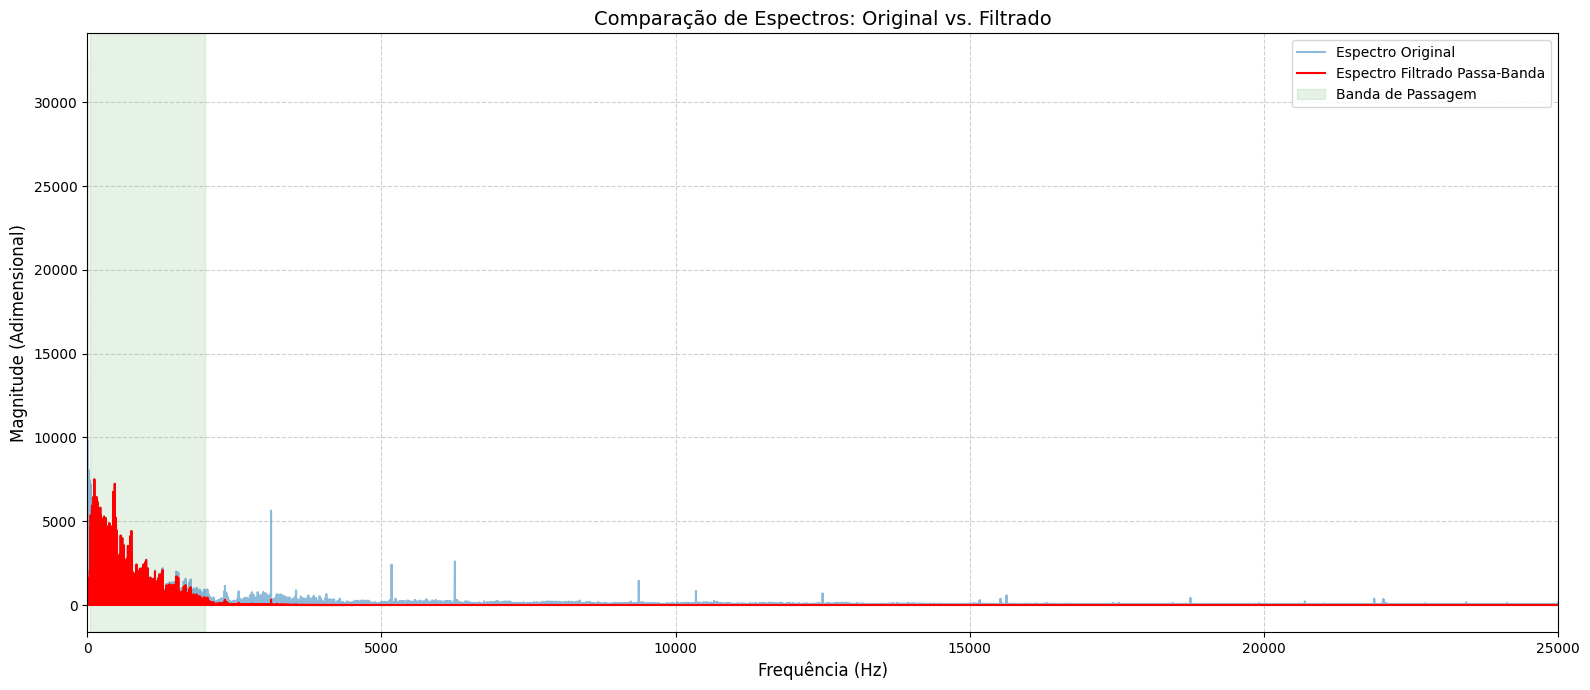


Filtro Passa-Banda aplicado e espectros comparados. O sinal 'signal_filtered' está pronto para a próxima etapa (e.g., Transformada de Hilbert para análise de envelope).


In [46]:
num_amostras_zoom_plot = 1000 # Para melhor visualização no tempo
t_axis = np.arange(num_amostras_zoom_plot) / SAMPLE_RATE

plt.figure(figsize=(16, 6))
plt.plot(t_axis, raw_imbal_signal[:num_amostras_zoom_plot], label='Sinal Original Normalizado', alpha=0.7)
plt.plot(t_axis, signal_filtered[:num_amostras_zoom_plot], label='Sinal Filtrado Passa-Banda', color='red', linewidth=1.5)
plt.title(f'Sinal de Aceleração: Original vs. Filtrado ({fc_low}-{fc_high} Hz)', fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Amplitude Normalizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 6. Plotar os Espectros (Original vs. Filtrado) para Análise em Frequência ---
N_fft = len(raw_imbal_signal)
xf_original, yf_original = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(raw_imbal_signal))
xf_filtered, yf_filtered = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(signal_filtered))

plt.figure(figsize=(16, 7))
plt.plot(xf_original, yf_original, label='Espectro Original', alpha=0.5)
plt.plot(xf_filtered, yf_filtered, label='Espectro Filtrado Passa-Banda', color='red', linewidth=1.5)
plt.axvspan(fc_low, fc_high, color='green', alpha=0.1, label='Banda de Passagem') # Destaca a banda
plt.title('Comparação de Espectros: Original vs. Filtrado', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Adimensional)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, nyquist) # Mostra todo o espectro até Nyquist
# Opcional: plt.xlim(0, 10000) # Para um zoom visual onde a banda de passagem estaria
plt.tight_layout()
plt.show()

print("\nFiltro Passa-Banda aplicado e espectros comparados. O sinal 'signal_filtered' está pronto para a próxima etapa (e.g., Transformada de Hilbert para análise de envelope).")

#### Estimativa de rotação

Análise: Para continuar o estudo precisamos determinar a rotaçaõ da máquina:

para determinar a velocidade da máquina a partir da coluna zero (sinal do tacômetro) do dataset scaled_imbal_signal (que, para manter a consistência, vamos referenciar como a coluna do tacômetro em X ou df_unbalance_20g_concatenated), utilizamos o princípio de que o tacômetro gera um pulso por rotação. O método padrão é contar o número de pulsos em um determinado período de tempo, e então converter essa contagem para Rotações por Minuto (RPM).

- Algoritmo para Determinar a Velocidade da Máquina (RPM):

   - Extrair o Sinal do Tacômetro: Obter a série de dados da coluna do tacômetro.
   - Identificar Pulsos: Detectar os eventos que representam uma rotação completa. Isso geralmente é feito identificando as transições (flancos de subida ou descida) do sinal que cruzam um determinado limiar.
   - Contar Pulsos: Contar o número total de pulsos detectados no período do sinal.
   - Calcular Duração do Sinal: Determinar a duração total em segundos do segmento de sinal analisado, usando a taxa de amostragem.
   - Calcular RPM: A fórmula é: RPM=(Numero de Pulsos/Duracao do Sinal em Segundos)×60

In [22]:
# 1. Extrair o sinal do tacômetro (Coluna 0)
COLUNA_TACOMETRO = 0
# X é o array numpy que contém todos os dados dos sensores. Então, o sinal do tacômetro é a coluna 0 de X.
sinal_tacometro = X[:, COLUNA_TACOMETRO] 

# 2. Parâmetros de Amostragem (do seu setup)
TAXA_AMOSTRAGEM = 50000 # Hz (50 kHz)

# 3. Calcular a Duração Total do Sinal em Segundos
duracao_sinal_s = len(sinal_tacometro) / TAXA_AMOSTRAGEM

# 4. Identificar Pulsos do Tacômetro. O tacômetro geralmente tem um sinal digital ou um pulso claro por revolução.
# Escolhemos um limiar que o sinal deve cruzar para ser contado como um pulso.

limiar_pulso = 2.5 # Este é um valor comum para sinais que alternam entre baixo e alto (e.g., 0 e 5V)

# Detectar os pontos onde o sinal cruza o limiar de baixo para cima (flancos de subida)
# np.where retorna os índices onde a condição é verdadeira.
# sinal_tacometro[:-1] compara todos os pontos exceto o último.
# sinal_tacometro[1:] compara todos os pontos exceto o primeiro.
# A condição detecta quando o ponto anterior estava abaixo do limiar e o ponto atual está acima ou igual.
indices_pulsos = np.where((sinal_tacometro[:-1] < limiar_pulso) & (sinal_tacometro[1:] >= limiar_pulso))[0]

# 5. Contar o Número de Pulsos
num_pulsos = len(indices_pulsos)

# 6. Calcular RPM
if duracao_sinal_s > 0:
    rpm_calculado = (num_pulsos / duracao_sinal_s) * 60
    print(f"\nVelocidade de Rotação da Máquina: {rpm_calculado:.2f} RPM")
else:
    rpm_calculado = 0
    print("AVISO: Duração do sinal de tacômetro é zero ou inválida. Não foi possível calcular o RPM.")

# Frequência de Rotação em Hz
frequencia_rotacao_hz = rpm_calculado / 60
print(f"Frequência de Rotação (f1): {frequencia_rotacao_hz:.2f} Hz")


Velocidade de Rotação da Máquina: 2202.13 RPM
Frequência de Rotação (f1): 36.70 Hz


- É importante esclarecer que, para sinais discretos como os que estamos tratando, a Transformada de Fourier comumente utilizada é a Transformada Discreta de Fourier (DFT), e sua implementação computacional eficiente é a Transformada Rápida de Fourier (rFFT).

- Com base nos dados fornecidos:

- sabendo que: 
   - Velocidade de Rotação da Máquina: 2202.13 RPM
   - Frequência de Rotação (f1): 36.70 Hz

- Frequência Fundamental de Rotação (1X RPM): 36.70 Hz. indica a velocidade da máquina.
- Harmônicos da Frequência de Rotação: São múltiplos inteiros da frequência fundamental. No contexto de desbalanceamento e outras falhas rotacionais, picos em 2X, 3X, 4X, etc., da frequência de rotação podem ser observados.
- 2X RPM: 2×36.70 Hz=73.40 Hz
- 3X RPM: 3×36.70 Hz=110.10 Hz
- 4X RPM: 4×36.70 Hz=146.80 Hz
E outros.

- Pontos no Gráfico da RFFT que Apontam para a Velocidade da Máquina. Procuremos por:

- O pico mais proeminente e alto localizado em aproximadamente 36.70 Hz. Este é o pico de 1X RPM, o indicador mais direto da velocidade de rotação, a mesma frequência do desbalanceamento. A altura (magnitude) deste pico na frequência de 36.70 Hz está diretamente correlacionada com a energia do sinal.
Picos menores (harmônicos) em múltiplos dessa frequência, como 73.40 Hz, 110.10 Hz, 146.80 Hz, etc.. Embora o desbalanceamento seja primariamente 1X, a presença de harmônicos pode indicar outros problemas rotacionais que interagem com o desbalanceamento, ou um desbalanceamento mais complexo.
Analisando a imagem do gráfico, o pico mais evidente na faixa de baixa frequência (onde o zoom seria mais útil) corresponderia à frequência de rotação. Sem o eixo X detalhado nessa imagem, a identificação exata é visual, mas a correlação é procurada nesses valores de frequência.